# openai_vision

> Exploring chatgpt_vision for vegan ingredient inferencing.

In [ ]:
#| default_exp openai_vision

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import base64
import json
import logging
import os
import statistics
import time
from functools import partial
from glob import glob
from logging.handlers import RotatingFileHandler
from pathlib import Path

import numpy as np
import requests
from PIL import Image

from openai import OpenAI
import constants

Inspiration drawn from [TaskMartix aka Visual ChatGPT](https://github.com/microsoft/TaskMatrix)

In [ ]:
#| hide
import markdown
from dotenv import load_dotenv
from ipywidgets import widgets
import os
from lv_recipe_chatbot.utils import load_json, dump_json

In [ ]:
#| hide
load_dotenv()


NB_STORE = str(constants.STORE_DIR / "04_gptv")
os.makedirs(NB_STORE, exist_ok=True)


def _store_json(data, fname: str):
    if fname.endswith(".json"):
        fname = fname[0:-5]
    return dump_json(data, NB_STORE + "/" + fname + ".json")


def _load_stored_json(fname: str):
    if fname.endswith(".json"):
        fname = fname[0:-5]
    return load_json(NB_STORE + "/" + fname + ".json")


logger = logging.getLogger()
logger.handlers.clear()
logger.setLevel(level=logging.INFO)
rfh = RotatingFileHandler("/tmp/04_gptv.log", maxBytes=5 * 1024 * 1024, backupCount=5)
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
rfh.setFormatter(formatter)
logger.addHandler(rfh)
logging.info("Begin")

In [ ]:
#| export
SAMPLE_IMG_DIR = Path(f"{constants.ROOT_DIR}/assets/images/vegan_ingredients")

In [ ]:
#| export
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [ ]:
#| export
# fmt: off
def format_image(
    image: str, # Image file path
    size: int = 300
):
    # fmt: on
    img = Image.open(image)
    width, height = img.size
    ratio = min(size / width, size / height)
    width_new, height_new = (round(width * ratio), round(height * ratio))
    width_new = int(np.round(width_new / 64.0)) * 64
    height_new = int(np.round(height_new / 64.0)) * 64
    img = img.resize((width_new, height_new))
    img = img.convert("RGB")
    return img

In [ ]:
sample_images = glob(f"{SAMPLE_IMG_DIR}/*.jpg")
sample_images

['/home/evylz/AnimalEquality/lv-recipe-chatbot/assets/images/vegan_ingredients/veg-groceries-table.jpg',
 '/home/evylz/AnimalEquality/lv-recipe-chatbot/assets/images/vegan_ingredients/fridge-splendid.jpg',
 '/home/evylz/AnimalEquality/lv-recipe-chatbot/assets/images/vegan_ingredients/veggie-fridge.jpg',
 '/home/evylz/AnimalEquality/lv-recipe-chatbot/assets/images/vegan_ingredients/neat-veg-groceries.jpg',
 '/home/evylz/AnimalEquality/lv-recipe-chatbot/assets/images/vegan_ingredients/fruits-and-vegetables-one-a-table.jpg',
 '/home/evylz/AnimalEquality/lv-recipe-chatbot/assets/images/vegan_ingredients/veg-groceries-table-2.jpg']

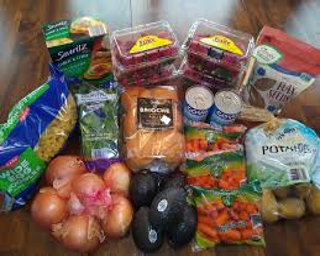

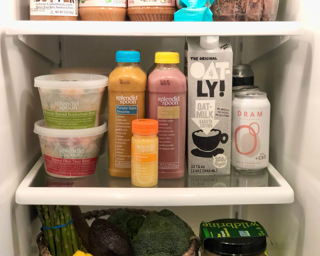

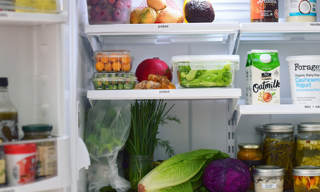

In [ ]:
for img in sample_images[0:3]:
    display(format_image(img))

In [ ]:
%%script echo skipping
client = OpenAI()

_response = client.chat.completions.create(
    model="gpt-4-vision-preview",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "What vegan ingredients are in this image?"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": "https://sweetsimplevegan.com/wp-content/uploads/2019/03/Vegan-Fridge-Tour-Our-Essentials-Sweet-Simple-Vegan-14.jpg",
                    },
                },
            ],
        }
    ],
    max_tokens=300,
)
_store_json(_response.choices[0].message.content, "first_gptv_test")

skipping


In [ ]:
print(_load_stored_json("first_gptv_test"))

This image shows a well-stocked fridge with a variety of items. Based on what's visible, we can identify several vegan ingredients and items:

1. Fruits & Vegetables: Asparagus, carrots, kale, strawberries, blueberries, lemons, limes, and any other visible produce not clearly identified.
2. Condiments and Sauces: There appear to be bottles that could be plant-based condiments and sauces. It's common to have vegan options among these, like soy sauce, hot sauce, mustards, and some salad dressings.
3. Plant-Based Milk: There seems to be a container that could possibly be a plant-based milk in the door shelf.
4. Nuts: There are jars possibly containing nuts, which are inherently vegan.
5. Hummus: The container in the door could be hummus, which is often vegan.
6. Jars and Cans: The jars and cans might include legumes, vegetables, or vegan spreads that are common in plant-based diets.
7. Vegan Mayonnaise: There is a jar labeled "Vegan Mayonnaise" in one of the door shelves.

Please note tha

<img src="https://sweetsimplevegan.com/wp-content/uploads/2019/03/Vegan-Fridge-Tour-Our-Essentials-Sweet-Simple-Vegan-14.jpg" style="width:300px"/>

In [ ]:
%%script echo skipping

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
}

payload = {
    "model": "gpt-4-vision-preview",
    "messages": [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "What’s in this image?"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{encode_image(sample_images[0])}"
                    },
                },
            ],
        }
    ],
    "max_tokens": 300,
}

response = requests.post(
    "https://api.openai.com/v1/chat/completions", headers=headers, json=payload
)

_store_json(response.json(), 'gptv_test_encode')

skipping


The image shows a collection of various grocery items laid out on a floor. There are fresh produce and packaged goods visible. I see onions, avocados, carrots, and what looks to be a bag of potatoes among the fresh produce. Packaged goods include a box of pasta, a can of beans, and some other items that are not clearly identifiable due to the resolution of the image. It looks like someone's grocery shopping, perhaps recently bought and unpacked.



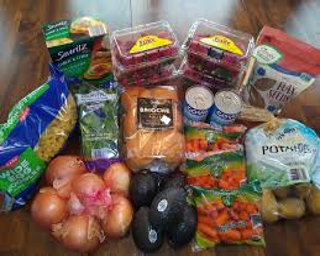

In [ ]:
print(_load_stored_json("gptv_test_encode")["choices"][0]["message"]["content"])
print()
display(format_image(sample_images[0]))

In [ ]:
#| export
# https://platform.openai.com/docs/guides/vision/low-or-high-fidelity-image-understanding
def get_gptv_completion(prompt: str, img: str, detail="low"):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
    }

    payload = {
        "model": "gpt-4o",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{encode_image(img)}",
                            "detail": detail,
                        },
                    },
                ],
            }
        ],
        "max_tokens": 300,
    }

    response = requests.post(
        "https://api.openai.com/v1/chat/completions", headers=headers, json=payload
    )
    return response.json()["choices"][0]["message"]["content"]

In [ ]:
%%script echo skipping
_store_json(get_gptv_completion("What is in this image?", sample_images[0]), "get_gptv_comp_test")

In [ ]:
print(_load_stored_json("get_gptv_comp_test"))

The image displays a variety of groceries, including:

- Fresh produce: onions, avocados, potatoes, celery, carrots
- Packaged produce: raspberries, spinach
- Packaged foods: bread, pasta, canned goods, cookies
- Baking supplies: sugar
- Dairy: milk or milk alternative

The items appear to be for general grocery shopping, consisting of both fresh and non-perishable items.


### Image annotations format from cocodataset
> https://cocodataset.org/#detection-2020 

#### Caption annotation set 2014
```json
{
    "info": {
        "description": "COCO 2014 Dataset",
        "url": "http://cocodataset.org",
        "version": "1.0",
        "year": 2014,
        "contributor": "COCO Consortium",
        "date_created": "2017/09/01"
    },
    "images": [
        {
            "license": 3,
            "file_name": "COCO_val2014_000000391895.jpg",
            "coco_url": "http://images.cocodataset.org/val2014/COCO_val2014_000000391895.jpg",
            "height": 360,
            "width": 640,
            "date_captured": "2013-11-14 11:18:45",
            "flickr_url": "http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg",
            "id": 391895
        },
    ]
    "annotations": [
        {
            "image_id": 522418,
            "id": 681330,
            "caption": "A woman wearing a net on her head cutting a cake. "
        },
    ]
```

#### Panoptic 2017 validation set
```json
    "images": [
        {
            "license": 4,
            "file_name": "000000397133.jpg",
            "coco_url": "http://images.cocodataset.org/val2017/000000397133.jpg",
            "height": 427,
            "width": 640,
            "date_captured": "2013-11-14 17:02:52",
            "flickr_url": "http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg",
            "id": 397133
        },
        ...
    ]
    "annotations": [
        {"segments_info": [
            {
                "id": 3226956,
                "category_id": 1,
                "iscrowd": 0,
                "bbox": [
                    413,
                    158,
                    53,
                    138
                ],
                "area": 2840
            }]
        "file_name": "000000000139.png",
        "image_id": 139
        }
    ],
    "categories": [
    {
        "supercategory": "person",
        "isthing": 1,
        "id": 1,
        "name": "person"
    },
    ]
```

## Use annotations

In [ ]:
annotations = load_json(f"{SAMPLE_IMG_DIR}/annotations.json")

In [ ]:
display(annotations["images"][0])
display(len(annotations["images"]))

{'file_name': 'fridge-splendid.jpg',
 'ingredients': ['oat milk',
  'brown rice taco bowl',
  'broccoli',
  'asparagus',
  'avocado',
  'nut butter']}

17

Test a layout of the annotation data using ipywidgets

In [ ]:
vboxes = []
for entry in annotations["images"]:
    image_widget = widgets.Image(
        value=open(f"{SAMPLE_IMG_DIR}/{entry['file_name']}", "rb").read(),
        format="png",
        layout=widgets.Layout(max_width="300px", max_height="300px"),
    )
    desc = widgets.HTML(value=f"<p>{'<br/>'.join(entry['ingredients'])}</p>")
    vbox = widgets.VBox(
        [image_widget, desc],
        layout=widgets.Layout(
            min_width="300px", margin="0px 10px 0px 10px", overflow="hidden"
        ),
    )
    vboxes.append(vbox)

# Combine all VBoxes into a single HBox

hbox = widgets.HBox(vboxes, layout=widgets.Layout(overflow="scroll"))

# Display the final layout
display(hbox)

In [ ]:
def eval_ingredient_prompt(prompt: str):
    data = []
    annotations = load_json(f"{SAMPLE_IMG_DIR}/annotations.json")
    for i, entry in enumerate(annotations["images"]):
        logging.info(f"On image {i} of {len(annotations['images'])}")
        msg = get_gptv_completion(prompt, f"{SAMPLE_IMG_DIR}/{entry['file_name']}")
        entry["gptv_completion"] = msg
        data.append(entry)
    return data

In [ ]:
#| export
prompt1 = "What vegan ingredients are in the image? Ouput as JSON list."

In [ ]:
%%script echo skipping
_store_json(eval_ingredient_prompt(prompt1), "prompt1_data")

skipping


In [ ]:
prompt1_data = _load_stored_json("prompt1_data")

In [ ]:
prompt1_data[0]

{'file_name': 'fridge-splendid.jpg',
 'ingredients': ['oat milk',
  'brown rice taco bowl',
  'broccoli',
  'asparagus',
  'avocado',
  'nut butter'],
 'gptv_completion': '```json\n[\n    "Oatly Oat Milk",\n    "Splendid Spoon Plant-Based Meals"\n]\n```'}

In [ ]:
def analyze_ingredient_results(data):
    metrics = []
    for d in data:
        output_entry = {
            "img": d["file_name"],
            "gptv_completion": d["gptv_completion"],
        }
        ing_checks = {}
        for ing in d["ingredients"]:
            ing_checks[ing] = ing in d["gptv_completion"].lower()

        output_entry["percent_ing_covered"] = round(
            sum(ing_checks.values()) / len(ing_checks.values()) * 100
        )
        output_entry["ingredient_checks"] = ing_checks

        metrics.append(output_entry)
    return metrics


def display_ingredient_results(metrics_data):
    vboxes = []
    mean_ing_covered_p = round(
        statistics.mean([d["percent_ing_covered"] for d in metrics_data])
    )
    display(
        widgets.HTML(value=f"<h3>Mean ingredients found: {mean_ing_covered_p}%</h3>")
    )
    for d in metrics_data:
        img = widgets.Image(
            value=open(f"{SAMPLE_IMG_DIR}/{d['img']}", "rb").read(),
            format="png",
            layout=widgets.Layout(max_width="200px", max_height="200px"),
        )
        texts = []
        for ing, is_in_msg in d["ingredient_checks"].items():
            text_color = "red"
            if is_in_msg:
                text_color = "green"

            w_txt = widgets.HTML(value=f"<span>{ing}</span>")
            w_txt.style.text_color = text_color
            texts.append(w_txt)
        w_percent_ing = widgets.HTML(
            value=f"<p style='font-weight: bold;'>Ingredients found: {d['percent_ing_covered']}%</p>"
        )
        w_completion = widgets.HTML(value=markdown.markdown(d["gptv_completion"]))
        vbox = widgets.VBox(
            [img, w_percent_ing] + texts + [w_completion],
            layout=widgets.Layout(
                min_width="200px", margin="0px 10px 0px 10px", overflow="hidden"
            ),
        )
        vboxes.append(vbox)

    hbox = widgets.HBox(vboxes, layout=widgets.Layout(overflow="scroll"))
    display(hbox)


display(widgets.HTML(value=f"<h3>Prompt: {prompt1}</h3>"))
display_ingredient_results(analyze_ingredient_results(prompt1_data))

HTML(value='<h3>Prompt: What vegan ingredients are in the image? Ouput as JSON list.</h3>')

HTML(value='<h3>Mean ingredients found: 50%</h3>')

Convert HEIC images (Apple format) to jpg using ImageMagick convert cli
```sh
for file in ./*.HEIC; do convert $file "${file%.HEIC}.jpg"; done 
```


Normalize .jpg file ending
```sh
for file in *.JPG; do
    mv "$file" "${file%.JPG}.jpg"
done
```

In [ ]:
#| export
extract_veg_ingredients = partial(get_gptv_completion, prompt1)

In [ ]:
%%script echo skipping
_store_json(extract_veg_ingredients(f"{SAMPLE_IMG_DIR}/{annotations['images'][-1]['file_name']}"), "extract_veg_ing_t")

skipping


HTML(value='<p><code>json\n[\n  "Cucumbers",\n  "Bell Peppers",\n  "Lettuce",\n  "Red Cabbage",\n  "Celery",\n…

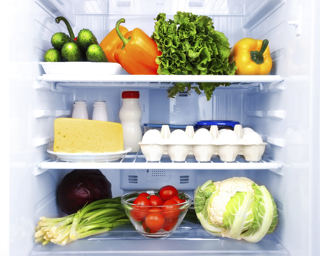

In [ ]:
display(widgets.HTML(value=markdown.markdown(_load_stored_json("extract_veg_ing_t"))))
display(format_image(f"{SAMPLE_IMG_DIR}/{annotations['images'][-1]['file_name']}"))

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()